# **Importing Libraries**

In [ ]:
pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD, KNNWithMeans
from surprise.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing and Cleaning Data**

In [ ]:
# Kelly File Path
rating_df = pd.read_csv('/content/drive/MyDrive/DS5230PROJECT/rating.csv')
movie_df =  pd.read_csv('/content/drive/MyDrive/DS5230PROJECT/movie.csv')

# Arya File Path
#rating_df = pd.read_csv('rating.csv')
#movie_df = pd.read_csv('movie.csv')

In [ ]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Check for missing values.**

In [ ]:
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

**Merge movie and ratings dataframes.**

In [ ]:
df = pd.merge(movie_df,rating_df, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


# **Exploratory Data Analysis (EDA)**

**Find how many unique movies and movie IDs exist in the dataset.**

In [ ]:
movies = list(df['title'].unique())

In [ ]:
len(movies)

27262

In [ ]:
movieId = list(df['movieId'].unique())

In [ ]:
len(movieId)

27278

**Find the percentage of movie genres that exist in the dataset.**

In [ ]:
top_genres = movie_df['genres'].explode().value_counts().head(10)
top_genres

Drama                   4520
Comedy                  2294
Documentary             1942
Comedy|Drama            1264
Drama|Romance           1075
Comedy|Romance           757
Comedy|Drama|Romance     605
Horror                   565
Crime|Drama              448
Drama|Thriller           426
Name: genres, dtype: int64

**Find the average rating of each movie**

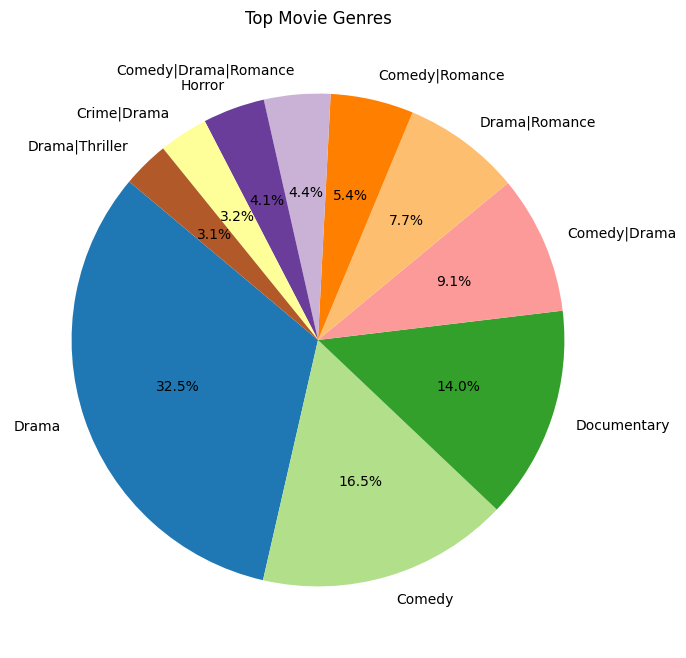

In [ ]:
# Choosing the colors - https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/
a = plt.cm.Paired

top_genres = movie_df['genres'].explode().value_counts().head(10)
colors = [a(0.1), a(0.2), a(0.3), a(0.4), a(0.5), a(0.6), a(0.7), a(0.8), a(0.9), a(0.99)]

# Create a pie chart of genre percentage breakdown
plt.figure(figsize=(8, 8))
plt.pie(top_genres.values, labels=top_genres.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top Movie Genres')
plt.show()

**Find how many ratings exist per movie and their average ratings.**

In [ ]:
# Group by movieId, calculate the mean of each rating
movie_ratings = df.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()

# Clean up by renaming columns
movie_ratings.columns = ['Movie ID', 'Number of Ratings', 'Average Rating']

# Sort the DataFrame in descending order based on 'num_ratings'
movie_ratings_sorted = movie_ratings.sort_values(by='Number of Ratings', ascending=False)
movie_ratings_sorted

,Movie ID,Number of Ratings,Average Rating
293,296,67310,4.174231
352,356,66172,4.029000
315,318,63366,4.446990
587,593,63299,4.177057
476,480,59715,3.664741
...,...,...,...
25157,118786,0,NaN
26514,127184,0,NaN
20219,99515,0,NaN
26517,127190,0,NaN


**Estimate NaN Ratings using KNNWithMeans**

In [62]:
from surprise.model_selection import train_test_split

# Convert NaN values to a placeholder (e.g., 0) for the surprise library
movie_ratings_sorted['Average Rating'].fillna(0, inplace=True)

# Create a Surprise dataset
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movie_ratings_sorted[['Movie ID', 'Number of Ratings', 'Average Rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use the KNNWithMeans for item-based collaborative filtering algorithm
sim_options = {
    'name': 'cosine',
    'user_based': False
}

algo = KNNWithMeans(sim_options=sim_options)

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Compute RMSE
print(f'RMSE on the test set: {accuracy.rmse(predictions)}')


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8031
RMSE on the test set: 0.8031322970317435


**Estimate NaN Ratings using SVD**

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy


# Fill NaN values with a placeholder
movie_ratings_sorted['Average Rating'].fillna(0, inplace=True)

# Create a Surprise dataset
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movie_ratings_sorted[['Movie ID', 'Number of Ratings', 'Average Rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use SVD algorithm
algo = SVD()

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test /train set
svd_test_predictions = algo.test(testset)



# Compute RMSE
print(f'RMSE on the test set: {accuracy.rmse(svd_test_predictions)}')

RMSE: 0.6576
RMSE on the test set: 0.6576026077809431


### Ratings for 10 random movies from test set that include actual and predicted ratings

In [54]:
random.seed(0)

# Select 10 random samples from the test set and generate predictions
predictions = [algo.predict(uid, iid, r_ui) for (uid, iid, r_ui) in random.sample(testset, 10)]

# Create a DataFrame with results
results_df = pd.DataFrame([
    {
        'User ID': prediction.uid,
        'Movie ID': prediction.iid,
        'Actual Rating': movie_ratings_sorted.loc[movie_ratings_sorted['Movie ID'] == prediction.iid, 'Average Rating'].values[0],
        'Predicted Rating': prediction.est
    }
    for prediction in predictions if len(movie_ratings_sorted.loc[movie_ratings_sorted['Movie ID'] == prediction.iid, 'Average Rating'].values) > 0
])

print(results_df)


   User ID  Movie ID  Actual Rating  Predicted Rating
0    98604        79       3.128546          3.144258
1    70204         2       3.211977          3.014810
2    54732       502       2.284047          3.053858
3    88181         5       3.064592          3.078389
4    73042       232       4.035610          3.099101
5   116859         3       3.151040          3.046264
6   111237         1       3.921240          2.949241
7    82842        11       3.667713          3.161590
8      459      1103       3.812048          3.138959


**Filter movies so most important are used.**

In [ ]:
# Create a mask to identify movies with ratings greater than or equal to 1000
rating_per_movie = df["title"].value_counts()

high_ratings = rating_per_movie[rating_per_movie > 1000].index
filtered_df = df[~df["title"].isin(high_ratings)]
filtered_df.head()

,movieId,title,genres,userId,rating,timestamp
411101,33,Wings of Courage (1995),Adventure|Romance|IMAX,1638.0,3.0,1996-07-02 00:09:43
411102,33,Wings of Courage (1995),Adventure|Romance|IMAX,3313.0,3.0,1996-07-16 17:09:46
411103,33,Wings of Courage (1995),Adventure|Romance|IMAX,5084.0,3.0,2000-08-16 21:18:10
411104,33,Wings of Courage (1995),Adventure|Romance|IMAX,7286.0,3.5,2005-03-18 22:36:07
411105,33,Wings of Courage (1995),Adventure|Romance|IMAX,7778.0,4.0,1999-10-25 08:51:33


**Prepare Dataset for Manipulation**

In [ ]:
# Subet of filtered dataframe
filtered_df_subset = filtered_df.head(100000)
filtered_df_subset

,movieId,title,genres,userId,rating,timestamp
411101,33,Wings of Courage (1995),Adventure|Romance|IMAX,1638.0,3.0,1996-07-02 00:09:43
411102,33,Wings of Courage (1995),Adventure|Romance|IMAX,3313.0,3.0,1996-07-16 17:09:46
411103,33,Wings of Courage (1995),Adventure|Romance|IMAX,5084.0,3.0,2000-08-16 21:18:10
411104,33,Wings of Courage (1995),Adventure|Romance|IMAX,7286.0,3.5,2005-03-18 22:36:07
411105,33,Wings of Courage (1995),Adventure|Romance|IMAX,7778.0,4.0,1999-10-25 08:51:33
...,...,...,...,...,...,...
4597502,753,"Month by the Lake, A (1995)",Comedy|Drama|Romance,128354.0,3.0,2001-07-25 15:17:44
4597503,753,"Month by the Lake, A (1995)",Comedy|Drama|Romance,128591.0,3.0,1999-10-02 20:53:21
4597504,753,"Month by the Lake, A (1995)",Comedy|Drama|Romance,128653.0,1.0,1997-01-29 16:05:35
4597505,753,"Month by the Lake, A (1995)",Comedy|Drama|Romance,128973.0,3.0,1996-12-01 17:16:48


In [ ]:
cleaned_df = filtered_df_subset.pivot_table(index="userId",columns="title",values="rating")

In [ ]:
cleaned_df

title,"301, 302 (301/302) (1995)",8 Seconds (1994),Above the Rim (1994),Across the Sea of Time (1995),"Addiction, The (1995)","Air Up There, The (1994)",All Things Fair (Lust och fägring stor) (1995),"Amazing Panda Adventure, The (1995)",And Nobody Weeps for Me (Und keiner weint mir nach) (1996),Andre (1994),...,"White Balloon, The (Badkonake sefid) (1995)",White Man's Burden (1995),Wild Bill (1995),Window to Paris (Okno v Parizh) (1994),Windows (1980),Wings of Courage (1995),"Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)","Wooden Man's Bride, The (Yan shen) (1994)","World of Apu, The (Apur Sansar) (1959)",Yankee Zulu (1994)
userId,,,,,,,,,,,,,,,,,,,,,
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138484.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cleaned_df.isnull().sum()

# **User Based Recommendation**

**Select a random representative user and determine the list of movies watched.**

In [ ]:
random_user = cleaned_df.sample(1,random_state=45).index[0]
print("Chosen Random User:", random_user)

Chosen Random User: 54617.0


In [ ]:
# Create a new df with the statistics from the random user
random_user_df = cleaned_df[cleaned_df.index==random_user]

# Create a list of all movies watched by random user
movies_watched = random_user_df.dropna(axis=1).columns.tolist()
movies_watched_df = cleaned_df[movies_watched]
movies_watched_df

title,Anne Frank Remembered (1995),Blue Sky (1994),"Boys of St. Vincent, The (1992)"
userId,,,
3.0,NaN,NaN,NaN
7.0,NaN,3.0,NaN
11.0,NaN,NaN,NaN
19.0,NaN,NaN,NaN
24.0,NaN,NaN,NaN
...,...,...,...
138474.0,NaN,NaN,NaN
138483.0,NaN,NaN,NaN
138484.0,NaN,NaN,NaN


**Determines the movies each user watches that are similar to the random user.**

In [ ]:
movie_count = movies_watched_df.notnull().sum(axis=1)
movie_count.max()

3

In [ ]:
# Find user IDs who have watched 60%+ movies voted by random user as similar users
same_movies = movie_count[movie_count > (movies_watched_df.shape[1] * 60 ) / 100].index
same_movies

Float64Index([   208.0,    620.0,    903.0,   1931.0,   2337.0,   2736.0,
                5110.0,   5814.0,   7727.0,   8405.0,
              ...
              129330.0, 130036.0, 132977.0, 133330.0, 135084.0, 135425.0,
              136222.0, 136679.0, 137057.0, 137479.0],
             dtype='float64', name='userId', length=174)

In [ ]:
# Lists of similar users and their ratings for the same movies watched
results_df = movies_watched_df[movies_watched_df.index.isin(same_movies)]
results_df

title,Anne Frank Remembered (1995),Blue Sky (1994),"Boys of St. Vincent, The (1992)"
userId,,,
208.0,3.5,NaN,5.0
620.0,NaN,4.0,5.0
903.0,3.0,2.0,NaN
1931.0,5.0,NaN,3.0
2337.0,5.0,4.0,NaN
...,...,...,...
135425.0,NaN,2.5,4.0
136222.0,3.0,NaN,3.0
136679.0,NaN,4.0,4.5


In [ ]:
# Correlation between representative users and similar users
corr_df = results_df.T.corr().unstack()
corr_df[random_user]

userId
208.0       NaN
620.0      -1.0
903.0      -1.0
1931.0      NaN
2337.0     -1.0
           ... 
135425.0   -1.0
136222.0    NaN
136679.0   -1.0
137057.0    NaN
137479.0    NaN
Length: 174, dtype: float64

In [ ]:
# Finds the top most similar users above a certain correlation coefficient
top_similar_users = pd.DataFrame(corr_df[random_user][corr_df[random_user] > 0.55], columns=["corr"])
top_users_ratings = pd.merge(top_similar_users, rating_df[["userId", "movieId", "rating"]], how='inner', on="userId")
top_users_ratings.head(10)

,userId,corr,movieId,rating
0,8963.0,0.866025,1,2.5
1,8963.0,0.866025,4,3.5
2,8963.0,0.866025,6,3.5
3,8963.0,0.866025,7,3.0
4,8963.0,0.866025,9,4.0
5,8963.0,0.866025,10,3.0
6,8963.0,0.866025,11,3.0
7,8963.0,0.866025,14,3.0
8,8963.0,0.866025,16,3.0
9,8963.0,0.866025,17,4.0


# **Item Based Recommendation**

In [ ]:
df_1 = movie_df.merge(rating_df, how="left", on="movieId")
df_1.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


In [ ]:
# Count the number of ratings for each movie
ratings_counts = pd.DataFrame(df_1["title"].value_counts())

# Filter movies with less than 1000 reviews
rare_movies = ratings_counts[ratings_counts["title"] <= 1000].index

# Remove rare movies
common_movies = df_1[~df_1["title"].isin(rare_movies)]

# Create user-movie matrix
user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")

In [ ]:
user_movie_df

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),...,Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zulu (1964),[REC] (2007),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138489.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#generate random movie from this list
unique_movie_names = common_movies['title'].unique()
random_movie_name = np.random.choice(unique_movie_names)
random_movie_name

'Harriet the Spy (1996)'

In [ ]:
#Compute similarity with randomly generated movie and all others
cosine_similarities = cosine_similarity(user_movie_df.fillna(0).T, user_movie_df[random_movie_name].fillna(0).values.reshape(1, -1))

In [ ]:
cosine_similarity_df = pd.DataFrame(cosine_similarities, index=user_movie_df.columns, columns=['Cosine similarity'])
cosine_similarity_df = cosine_similarity_df.apply(lambda x: x.sort_values(ascending=False), axis=1)

In [ ]:
print("These are the top 10 movies with high correlation for the movie ",random_movie_name)
cosine_similarity_df.head(10)

These are the top 10 movies with high correlation for the movie  Harriet the Spy (1996)


,Cosine similarity
title,
"'burbs, The (1989)",0.081413
(500) Days of Summer (2009),0.027225
*batteries not included (1987),0.045602
...And Justice for All (1979),0.027199
10 Things I Hate About You (1999),0.110387
"10,000 BC (2008)",0.018965
101 Dalmatians (1996),0.183105
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.140697
102 Dalmatians (2000),0.087991


# Association Rules

In [ ]:
dframe = pd.merge(movie_df,rating_df)
df.drop(columns=['timestamp','genres'],inplace=True)

In [ ]:
merge_list = dframe.groupby(by = ["userId"])["title"].apply(list).reset_index()
merge_list.head()

In [ ]:
merge_list = merge_list["title"].tolist()
merge_list[0:3]

Data Transformation

In [ ]:
#transform dataset into a one-hot encoded numpy array and then a pandas df
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_arr = te.fit(merge_list).transform(merge_list)
df1 = pd.DataFrame(te_arr, columns=te.columns_)

Generating frequent itemsets and Analysis of Aprioiri application

In [ ]:
from mlxtend.frequent_patterns import apriori
apriori_frequent_itemsets = apriori(df1, min_support=0.2,use_colnames=True)
apriori_frequent_itemsets

##### Association Rules

In [ ]:
#using Lift as a score evaluating method
from mlxtend.frequent_patterns import association_rules
rules = association_rules(apriori_frequent_itemsets,metric="lift",min_threshold=0.01

In [ ]:
#rules  that with a lift greater or equal to one
rules = association_rules(apriori_frequent_itemsets,metric="lift",min_threshold=1)
rules

Top 10 related movies to a specific one. In this case " Forest Gump"

In [ ]:
rules[rules["antecedents"].apply(lambda x: "Forrest Gump (1994)" in str(x))].groupby(
    ['antecedents', 'consequents'])[['lift']].max().sort_values(ascending=False,by='lift').head(10)

In [ ]:
rules[rules["antecedents"].apply(lambda x: "Forrest Gump (1994)" in str(x))].groupby(
    ['consequents'])[['confidence']].max().sort_values(ascending=False,
                                                 by='confidence').head(10).plot(kind='barh')
plt.title('Movies likely to be watched by "Forrest Gump (1994)" viewers ');